![title](xsfa_flat.png)

# An extension to Slow Feature Analysis (xSFA)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*tutorial by Nils Müller and Fabian Schönfeld*

Following our [previous tutorial](https://hackernoon.com/a-brief-introduction-to-slow-feature-analysis-18c901bc2a58) on [*Slow Feature Analysis*](http://www.scholarpedia.org/article/Slow_feature_analysis) (SFA) we now talk about *xSFA* - an *unsupervised learning* algorithm and extension to the original SFA algorithm that utilizes the *slow features* generated by SFA to reconstruct the individual *sources* of a *nonlinear mixture*, a process also known as *Blind Source Separation* (e.g. the reconstruction of individual voices from the recording of a conversation between multiple people).

Formally, "nonlinear mixture" refers to a nonlinear function of a single point in the source space (this rules out operators like convolutions) which may be called *point-nonlinear*. The objective of the xSFA algorithm is to approximate the inverse of this function. The reconstructed sources extracted by xSFA can thus be understood as the arguments of a function composition. Due to this explicit use case the results of xSFA tend to be easier to interpret than the features found by the original SFA algorithm.

In this tutorial, we will provide a short example to demonstrate the capabilities of xSFA, discuss its limits, and offer some pointers on how and when to apply it. We also take a closer look at the theoretical background of xSFA to provide an intuition for the mathematics behind it.


#### Table of contents

   1. [Generating a nonlinear mixture](#section 1)
   2. [Applying xSFA](#section 2)
   3. [Results](#section 3)
   4. [xSFA theory](#section 4)
   5. [Practical limitations of xSFA](#section 5)
   6. [References](#section 6)
   7. [References](#section 7)

We start by importing all the libraries we will need in this example. This includes the widely used numpy and matplotlib libraries, as well as our own machine learning library [mdp](http://mdp-toolkit.sourceforge.net/). The latter contains a number of data processing routines including SFA and variants such as xSFA.

In [2]:
# tell jupyter to produce inline plots
%matplotlib inline  

# import everything we need
import matplotlib.pyplot as plt
import mdp
import numpy as np
from   scipy.io import wavfile

## 1. Generating a nonlinear mixture of sources<a id="section 1"> </a>


For our purposes we construct an example using two sources only: $(s_{1,n})_{n \in I \subset \mathbb{N}}$ and $(s_{2,n})_{n \in I \subset \mathbb{N}}$. We assume these sources to be statistically independent, as this is a requirement for the successful application of xSFA. Note that while in practice this requirement can be difficult to verify, we typically assume it when applying xSFA.

For our sources, we choose two sound samples [[6](#fn6), [7](#fn7)] from Freesound [[5](#fn5)] available under the creative commons license. In the following code, we load the samples into numpy arrays and visualize the amplitudes of both samples before they are mixed together. When visualizing the sources as reconstructed by xSFA later, this plot is what we are hoping to approximate.

('Shape of sequence 1: ', (682840,), '// Shape of sequence 2: ', (682840,))
('Frequency of sequence 1 (Hz): ', 44100, '// Frequency of sequence 2 (Hz): ', 44100)


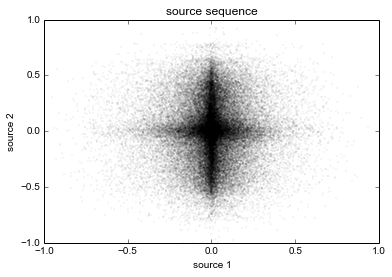

In [4]:
# get sound data
fs1, s1 = wavfile.read( 'airraidsiren.wav' )
fs2, s2 = wavfile.read( 'housemusic.wav'   )

# make sure source sequences have the same length, the correct data type and are bounded by 1,-1
s1 = s1[ : np.min((s1.shape[0],s2.shape[0])) ].astype( 'float64' )
s1 = s1/np.max( np.abs(s1) ) # scaled in order to produce the twirling mixture seen further below
s2 = s2[ : np.min((s1.shape[0],s2.shape[0])),0 ].astype( 'float64' )
s2 = s2/np.max( np.abs(s2) ) # scaled as above

# print source information
print( 'Shape of sequence 1: ', s1.shape, '// Shape of sequence 2: ', s2.shape )
print( 'Frequency of sequence 1 (Hz): ', fs1, '// Frequency of sequence 2 (Hz): ', fs2 )

# visualize downsampled source sequence
plt.plot( s1[::10], s2[::10], 'kx', markersize=.1 )
plt.xlabel( 'source 1' )
plt.ylabel( 'source 2' )
plt.title ( 'source sequence' )
plt.show()

# find source code for this function in the appendix
timeplot( s1[::10], s2[::10], fs1, 'source 1', 'source 2' )

Next, we perform the following nonlinear mixture of our sources, resulting in sequence $\textbf{x}_n = (x_{1,n}, x_{2,n})_{n\in I}$: __[Question 1](#Q1)__ <a id="Q1t"> </a>

$$\begin{equation}
    x_{1,n} = (s_{2,n} + 3 s_{1,n} + 6) \cdot \text{cos}(1.5 \pi s_{1,n})
\end{equation}$$

$$\begin{equation}
    x_{2,n} = (s_{2,n} + 3 s_{1,n} + 6) \cdot \text{sin}(1.5 \pi s_{1,n}).
\end{equation}$$

In practice this function will be unknown. The point of xSFA is to find the inverse of this mixture given only $\textbf{x}_n$: the result of the mixture applied to the original sources. Note that for the successfull application of xSFA, the properties of the mixture are essential. The function is generally assumed to be invertible when restricted to its image (i.e. injective) and its inverse assumed to be at least approximable by polynomials of moderate order (see [Practical limitations](#section 5) for details). 

In our case, if the sources are not scaled appropriately we lose the injective property of our mapping and thus the example collapses (you can see this effect when, in the above code, removing the two lines with the ```# scaled``` comment).

Note that in general the mixture does not need to be of the same dimensionality as the input. In fact, the precise number of original sources embedded within a mixture is often unknown and subject to estimation.

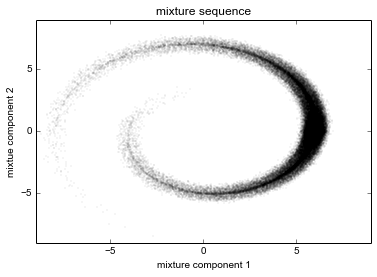

In [5]:
# do the nonlinear transformation
x1 = np.multiply( s2 + (3*s1) + 6, np.cos(1.5*np.pi*s1) )
x2 = np.multiply( s2 + (3*s1) + 6, np.sin(1.5*np.pi*s1) )

# visualize downsampled mixture sequence
plt.plot( x1[::10], x2[::10], 'kx', markersize=.1 )
plt.axis( [-9, 9, -9, 9] )
plt.xlabel( 'mixture component 1' )
plt.ylabel( 'mixture component 2' )
plt.title( 'mixture sequence' )
plt.show()

# find source code to for this function in the appendix
timeplot( x1[::10], x2[::10], fs1,
 'mixture component 1', 'mixture component 2' )

## 2. Applying xSFA<a id="section 2"> </a>

In practice the sequence $\textbf{x}$ is the only available information and forms the input for xSFA. The objective of xSFA is now to identify the inverse of the unknown mixture and, using that, to reconstruct the original sources $s_1, s_2$. Formally: we want xSFA to return an estimation $\hat{s}_j$ for each source $s_j$ (from here on out we use the $\hat{\cdot}$-operator to denote estimations).

By defining our sources as a sequence, we implicitly assumed both the sources and their mixtures to be ordered. However, note that xSFA does not require the sequences to be ordered by time. Any concept of an order will do but will influence the intuition behind the slowness principle, as slowness then represents small variation of the recorded sequence not in time but in increase of another quantity (e.g. space when recording multidimensional movement).__[Question 3](#Q3)__ <a id="Q3t"> </a>

In order to run xSFA we have to set the following [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_%28machine_learning%29):

* $n_s$ **:** Number of sources to estimate.

* $o_{\text{mix}}$ **:** Order of the expansion that is applied to the mixture. This parameter limits the function space within which xSFA will attempt to find an approximation of the inverse to the mixture. Typical values are in the range $10 \leq o_{\text{mix}} \leq 20$. (Note: While a higher value for this paramater increases the approximative capability of xSFA it will also quickly incur the curse of dimensionality; see [section 5](#section 5) for details.)

* $o_{\text{est}}$ **:** Order of the expansion applied to the already estimated sources during each iteration of xSFA. Higher values increase the power of xSFA to differentiate the estimated sources from each other within the mixture. (Note: As with $o_{\text{mix}}$, higher values are analytically better but will run into a variety of other problems; see [section 5](#section 5) for details.)

In [6]:
o_mix = 15   # expansion order of the mixture
o_est = 13   # expansion order of the estimated sources
n_s   = 2    # number of sources to estimate

# initialise expansion nodes
basic_exp  = ( mdp.nodes.PolynomialExpansionNode, (o_mix, ), {} )
intern_exp = ( mdp.nodes.PolynomialExpansionNode, (o_est, ), {} )

# initialize xSFA
xsfa = mdp.nodes.XSFANode( basic_exp=basic_exp, intern_exp=intern_exp, output_dim=n_s )

# compute the slow features
s_est = xsfa.execute( np.transpose(np.array([x1,x2])) )

## 3. Results <a id="section 3"> </a>


We can now listen to the reconstructed sources $\textbf{s}_{est} = (\hat{s}_1, \hat{s}_2)$ stored in ```s_est```. The twirling shape of the data has been unwrapped by xSFA and the sound files have remarkably increased in quality. The different scaling of the result below, when compared to the generated sources, is due to the unit variance constraint in SFA known from the [previous tutorial](https://hackernoon.com/a-brief-introduction-to-slow-feature-analysis-18c901bc2a58), which introduces a deviation of the result from the original sources by a constant factor.

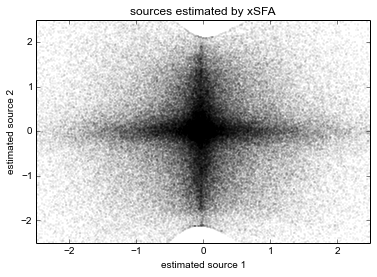

In [9]:
# visualize downsampled source estimation
plt.plot( s_est[:,0][::4], s_est[:,1][::4], 'kx', markersize=.1 )
plt.axis( [-2.5, 2.5, -2.5, 2.5] )
plt.xlabel( 'estimated source 1' )
plt.ylabel( 'estimated source 2' )
plt.title( 'sources estimated by xSFA' )
plt.show()

# find source code to for this function in the appendix
timeplot( s_est[:,0][::4], s_est[:,1][::4], fs1,
 'estimated source 1', 'estimated source 2' )

# write sounds to file
wavfile.write( 'sourceestimation1.wav', fs1, s_est[:,0] )
wavfile.write( 'sourceestimation2.wav', fs2, s_est[:,1] )
wavfile.write( 'mixture1.wav', fs1, x1 )
wavfile.write( 'mixture2.wav', fs2, x2 )

Other than a difference in scaling, our reconstructed signals come fairly close to the original sources depicted earlier.

## 4. xSFA theory  <a id="section 4"> </a>

Note: A variable list can be found in the [appendix](#section 7).
### 4.1. What is happening?  <a id="section 4.1"> </a>

In brief, the xSFA algorithm is based on the iterative application of SFA in order to retrieve an approximation of the original source sequences -- one source per iteration, to be precise. The core idea consists of repeatedly applying SFA in order to first extract the slowest feature from the mixture and then remove the just extracted feature (and anything we relate to it) from the remaining mixture. The accumulated set of the individual slowest features extracted during each iteration is returned as an approximation of the original sources. [[1](#fn1)] provides an intuition to relate the slow features of the mixture to the sources we are looking for:

> Blaschke et al. (2007) have proposed to use the tendency of nonlinearly distorted versions of the sources to vary more quickly in time than the original sources.  A simple illustration of this effect is the frequency doubling property of a quadratic nonlinearity when applied to a sine wave. **This observation opens the possibility of finding the original source (or a good representative thereof) among all the nonlinearly distorted versions by choosing the one that varies most slowly in time.**

In the following, we'll take a brief look at the individual steps of the xSFA algorithm, followed by a more detailed discussion on the how and why of each step. For a full introduction to xSFA see [[1](#fn1)]; for SFA we refer to [[2](#fn2), [3](#fn3), [4](#fn3)].

A word on notation: To make the math ahead easier to parse we use the $\hat{\cdot}$-operator to denote estimations as well as the $\tilde{\cdot}$-operator to denote expanded and not (yet) normalized sequences.

The general flow of xSFA is illustrated here (picture taken from [[1](#fn1)]):

<img src="xsfa_illustration.png" alt="Drawing" style="width: 400px;"/>

where the individual steps of xSFA can be summarized as follows (adapted from [[1](#fn1)]):

> **0.** Input data is the nonlinear mixture $\textbf{x}$ of $n_s$ unknown sources $s_{1,..,n_s}$.

> **1.** Start with iteration index $j=1$ to denote the extraction of the $j$-th source.

> **2.** Apply a polynomial expansion of order $o_{\text{mix}}$ to the nonlinear mixture $\textbf{x}$ to obtain the expanded mixture $\tilde{\textbf{z}}^j$.

> **3.** Apply linear SFA to the expanded mixture $\tilde{\textbf{z}}^j$. Store the slowest feature provided by linear SFA as an estimate $\hat{s}_j$ of source $s_j$.

> **4.** Apply a polynomial expansion of order $o_{\text{est}}$ to the estimated sources $\hat{s}_{1,..,j}$ and normalize the result. We refer to this nonlinear, expanded version of the approximated first $j$ sources as $\ \tilde{\textbf{u}}^j = (\tilde{u}_1^j, ..., \tilde{u}_{p_{o_{est},j}}^j)$ where $p_{o_{est},j}$ denotes the dimension of a polynomial expansion of degree $o_{\text{est}}$ of $j$ sequences.

> **5.** Remove the nonlinear versions of the first $j$ sources from the expanded mixture $\tilde{\textbf{z}}^j$:

> > **5.1.** For each $\tilde{z}_r^j$ in $\tilde{\textbf{z}}^j$ assign $\tilde{z}_r^{j+1} \leftarrow \tilde{z}_r^j - \sum\limits_{k=1}^{p_{o_{est},j}} \text{cov}( \tilde{z}_r^j, \tilde{u}_k^j )\tilde{u}_k^j$.

> > **5.1.** Remove principal components with a variance below a given threshold $\epsilon$.

> **6.** If $j$ equals the number of estimated sources $n_s$, return $\textbf{s}_{est} = (\hat{s}_1,..,\hat{s}_{n_s})$ and quit. Otherwise increase iteration index $j$ by $1$ and continue with step **3**.

### 4.2. How it works  <a id="section 4.2"> </a>

Let's take a closer look at the different computational steps of xSFA. For more information and a complete formal treatment of xSFA we refer to [[1](#fn1)].


* **_Expansion:_** Initially we would like to find a map $g^j$ that reconstructs the slowest source from the given sequence $\textbf{x}$ (i.e. $g^1(\textbf{x}) = s_1 \approx \hat{s}_1 = \hat{g}^1(\textbf{x})$, if $s_1$ is the slowest source, then $\hat{s}_1$ is our respective approximation), which we can assume to exist due to the assumed injective property of our mixture function. Slowness of the $j$-th source is measured as per estimation of $\mathbb{E}{\left( \dot{s}_j^2   \right)}$ as in SFA. Due to the approximative properties of polynomials (see [Stone–Weierstrass theorem](https://en.wikipedia.org/wiki/Stone%E2%80%93Weierstrass_theorem)) and their efficient computability on contemporary hardware, we reduce the problem to finding a polynomial approximation $\hat{g}^j$ of the map $g^j$ (the chosen order of polynomials is denoted by the hyperparameter ```o_mix``` / $o_{\text{mix}}$ as seen in the code example). In the following we will use the fact that the $\mathbb{R}$-vectorspace of all polynomials of the $d$-dimensional mixture $\textbf{x}$ up to the $o_{\text{mix}}$-th degree $\mathbb{R}[\textbf{x}]^{\leq o_{\text{mix}}}$ is isomorphic to $\mathbb{R}^{\dim{\mathbb{R}[\textbf{x}]^{\leq o_{\text{mix}}}}}$, the $\dim{\mathbb{R}[\textbf{x}]^{\leq o_{mix}}}$-dimensional $\mathbb{R}$-vectorspace $\mathbb{R}$. In other words: This enables us to solve our problem in $\mathbb{R}^{\dim{\mathbb{R}[\textbf{x}]^{\leq o_{\text{mix}}}}}$ given we find a base for $\mathbb{R}[\textbf{x}]^{\leq o_{\text{mix}}}$.  

  Thus, as in SFA, we will consider a transformation of mixture sequence elements to $\mathbb{R}^{ p_{o_{mix},d}}$, where $p_{o_{\text{mix}},d}$ is the number of non-constant monomials up to degree $o_{\text{mix}}$ that can be generated from $d$-dimensional mixture elements $\textbf{x}_i$ (minus the constant term; as in the next step a constant term will be removed during normalization). For example, given the polynomial degree $o_{\text{mix}} = 2$, the $i$-th element of our two dimensional mixture sequence $\textbf{x}_i = (x_{1,i}, x_{2,i})$ will initially (before finding the $j=1$-st source) be mapped to
  
  $$\begin{equation}\tilde{\textbf{z}}^1(\textbf{x}_i) = (\tilde{z}^1_{1}(\textbf{x}_i), ..., \tilde{z}^1_{p_{2,2}}(\textbf{x}_i)) = ( x_{1,i}, x_{2,i}, x_{1,i} \cdot x_{2,i}, x_{1,i}^2, x_{2,i}^2 ).\end{equation}$$
   
  This nonlinear transformation of the mixture sequence enables SFA to search for a *linear function* of our *nonlinear monomials* (as they are basis functions of a suitable function space, meaning: We can represent any polynomial up to degree $o_{\text{mix}}$ by linearly combining them), instead of searching for nonlinear $\hat{g}^j$. Notably, SFA does rely on the polynomial expansion to be of high enough degree in order to provide a good estimation of the inverse of the mixture. The idea can be extended to other linearly independent functions (as opposed to monomials) as long as their linear combinations can provide good estimations to the inverse of the mixture function.


* **_Linear SFA:_** First the expanded mixture $\tilde{\textbf{z}}^j$ is normalized (involving [whitening](https://en.wikipedia.org/wiki/Whitening_transformation) and substraction of the mean) to fulfill the SFA constraints of zero mean and unit variance of the following projections, namely our slow features. SFA then attempts to find a unit-length vector $w^j \in \mathbb{R}^{p_{o_{mix},d}}$ to project the normalized mixture $\textbf{z}^j$ on, such that slowness is maximized for the resulting polynomial map $\hat{g}^j(\textbf{x}_i) = {(w^j)}^T\textbf{z}^j(\textbf{x}_i)$. Here the constraints of SFA limit our search space to the unit length subset of $\mathbb{R}^{p_{o_{mix},d}}$ from which we draw the weights for the basis functions (the monomials) of our function space. The vector $w^j$ is computed by approximating the derivative of the normalized mixture sequence __[Question 4](#Q4)__ <a id="Q4t"> </a>

  $$\begin{equation}
  \dot{\textbf{z}}^j(\textbf{x}_i) \approx \textbf{z}^j(\textbf{x}_i)-\textbf{z}^j(\textbf{x}_{i-1})
  \end{equation}$$
  
  and computing the shortest eigenvector of the covariance matrix estimation of the derivative signal $\hat{C}^j = \mathrm{Cov}( \dot{\textbf{z}}^j(\textbf{x}))$, corresponding to the estimated direction of lowest variance and thus the one-dimensional subspace of $\mathbb{R}^{p_{m,d}}$ projected on which $\textbf{z}^j$ is expected to be slowest. Note that this process of computing the shortest eigenvector of $\hat{C}^j$ is a closed form solution method to the optimization problem of SFA.

  Now that we can extract the slowest feature we need to relate it to our not yet found source. This can be done by going back to the initial requirement of our sources: Due to the statistical independence of the sources the problem is separable into finding the single slowest and not yet found source $s_j$. From the previous paragraph we know: The slowest feature is the polynomial corresponding to the unit-length vector in direction of minimal variance (that is constructed from the slowest non-trivial solution to the eigenvalue problem). Additionally, a further implication of the statistical independence is that the slowest feature resembles the slowest source up to monotonic transformations. Thus $\hat{g}^j \approx s_j$ can be seen as a good representative of the slowest not yet found source $s_j$.


* **_Expansion of reconstruction:_** The slow features $\hat{g}^j$ we extract represent our estimations of the sources $s_j$. If we think of our slow features to be ordered sequences in the same space as our sources, it seems natural to not only consider linear dependencies of the respective slow features (as in SFA), but also nonlinear dependencies induced by our nonlinear mixture function. The iterative nature of our approach gives us the burden and the assumed statistical independence of the sources the opportunity (see xSFA paper or previous paragraph) to stepwise compute the source estimations. This is in contrast to computing all slow features as the eigenvectors of the same matrix at once as in regular SFA. Accordingly, we will polynomially expand the sources estimated so far $\hat{g}^{1,...,j}$ similar to the mixture sequence ($\hat{g}^{1,...,j}$ are the variables now instead of $x_1, x_2$), resulting in a sequence 

  $$\begin{equation}  \tilde{\textbf{u}}^j(\textbf{x}_i) = (\tilde{u}_1^j(\textbf{x}_i), ..., \tilde{u}_{p_{o_{est},j}}^j(\textbf{x}_i))  \end{equation}$$

  containing all $p_{o_{\text{est}},j}$ monomials up to degree $o_{\text{est}}$ attainable from the source estimations $\hat{g}^1(\textbf{x}_i), ..., \hat{g}^j(\textbf{x}_i)$ for the $i$-th sequence element. As in the expansion of the mixture sequence, the constant (hyperparameter) $o_{\text{est}}$ (```o_est```) determines the order of nonlinear functions to consider and restricts the complexity of our estimation.


* **_Decorrelation of expanded mixture and expanded reconstruction:_** In order to make sure the subsequently computed slow features are good estimations of the actual single sources (thus are only dependend on one of the sources), xSFA decorrelates the expanded mixture $\tilde{\textbf{z}}^j(\textbf{x}_i)$ with the expanded estimation of the $j$ slowest sources $\tilde{\textbf{u}}^j(\textbf{x}_i)$

  $$\begin{equation}  \tilde{z}^{j+1}_{r}(\textbf{x}_i) = \tilde{z}^j_{r}(\textbf{x}_i) - \sum_{k=1}^{p_{o_{est},j}} cov(\tilde{z}^j_{r}, \tilde{u}_k^j) \tilde{u}_k^j(\textbf{x}_i),  \end{equation}$$

  with $r\in \{1, ..., p_{o_{est},d} \}$ and $i \in I$. Due to the statistical independence, the expanded mixture factorizes into nonlinear functions of single sources allowing the decorrelation operation to rid the expanded mixture of components dependent on the already found sources.


* **_Loop:_** We repeat the process for the expanded mixture $\tilde{\textbf{z}}^{j+1}$ - which ideally contains information about not yet found sources exclusively - starting at "**_(Linear) SFA_**" after we set $j \leftarrow j + 1$. xSFA is terminated when the desired number of sources $n_s$ has been estimated.

## 5. Practical limitations of xSFA  <a id="section 5"> </a>


* Comparable to the frequency resolution of FFT's, there is a resolution for differentiating sources by their
  slowness which affects the __sampling time__. One can quantify the required sampling time as follows:
  $$\begin{equation}
  T \sim \tau \left(\frac{\Delta}{\delta}\right)^2
  \end{equation}$$
  $T$               - duration of the training data (sampling time)
  
  $\Delta$          - slowness of a source
  
  $\Delta + \delta$ - slowness of another source
  
  $\tau$            - autocorrelation time of the sources with $\tau \approx \frac{1}{\sqrt{\Delta}}$


* The __sampling rate__ of the data should be high enough to represent correlations correctly, but as the total data
  points are limited by the memory capacity of the computer, the sampling rate should be low enough to s.t. the total
  data includes enough "independent periods" and sparsity is thus limited.
  
  
* The __density of eigenvalues__, i.e. the similarity of the slowness of different reconstructions plays a key role
  in their quality. Not only similar sources but also a large number of sources to reconstruct can - under some 
  assumptions on the distribution of a source - impair the discriminative capability of xSFA.


* The __function space__ accessible to xSFA is determined by the basis functions used. A bad choice of basis  functions (e.g. only relatively low degree monomials) can severely limit the approximative capability of xSFA and
  cause source reconstructions to be mixtures of multiple sources. When using high degree monomials one can - in the
  standard xSFA implementation - experience problems with floating point precision. In order to prevent overfitting, 
  the complexity of the basis functions (i.e. the degree of polynomials used) should be picked with care and in
  relation to the amount of data available.
  
  
* The __time and memory requirements__ of xSFA can easily become gigantic if the number of basis elements required
  to access a function space increase strongly. When using polynomials up to degree $m$ and of dimension $h$, the
  number of basis elements required for xSFA is
  
  $$\begin{equation}
  p_{m,h} = \sum\limits_{0< k \leq h}{m+k-1\choose k-1} = \dim{\mathbb{R}[\textbf{x}]^{\leq m}} - 1
  \end{equation}$$
  
  where $\textbf{x}$ is in $\mathbb{R}^h$. We use the normaliztion operation to ensure zero mean source estimations, 
  hence the $-1$ in the right part of the equation. Although this already amounts to a huge order of growth in space 
  and time, the requirements are extended to $\mathcal{O}(p_{m,h}^3)$ in time complexity as well as $\mathcal{O}
  (p_{m,h}^2)$ in space complexity due to the matrix operations required by xSFA, such as the eigenvalue 
  decompositions. Consequently, this strongly limits the function space accessible for our reconstructions 
  $\hat{g}^j$ and should be kept in mind, especially in cases where there is little information about the mixture 
  function (thus bounds can hardly be assumed).

## 6. References  <a id="section 6"> </a>

<a name="fn1">[1]</a>: [Sprekeler et. al. (2014) *An Extension of Slow Feature Analysis for Nonlinear Blind Source Separation*](http://www.jmlr.org/papers/volume15/sprekeler14a/sprekeler14a.pdf)

<a name="fn2">[2]</a>: [Wiskott and Sejnowski (2002) *Slow Feature Analysis: Unsupervised Learning of Invariances*](https://www.mitpressjournals.org/doi/10.1162/089976602317318938)

<a name="fn3">[3]</a>: [SFA on Scholarpedia](http://www.scholarpedia.org/article/Slow_feature_analysis)

<a name="fn4">[4]</a>: [*A brief introduction to Slow Feature Analysis*](https://hackernoon.com/a-brief-introduction-to-slow-feature-analysis-18c901bc2a58) by [Hlynur Davíð Hlynsson](https://www.ini.rub.de/the_institute/people/hlynur_david-hlynsson/)

<a name="fn5">[5]</a>: [freesound.org](https://freesound.org/)

<a name="fn6">[6]</a>: Audio sample $s_1$: *"[House Music Loop](https://freesound.org/people/RavingRiverHorse/sounds/341330/)"* by user [RavingRiverHorse](https://freesound.org/people/RavingRiverHorse/)

<a name="fn7">[7]</a>: Audio sample $s_2$: *"[Air Raid Siren](https://freesound.org/people/cocaine/sounds/157463/)"* by user [cocaine](https://freesound.org/people/cocaine/)

## 7. Appendix: Variable list <a id="section 7"> </a>

* $s_j$                  - $j$-th source sequence
* $I$                    - sampling interval of our sequences, $I \subset \mathbb{N}$
* $\textbf{x}$           - mixture sequence
* $d$                    - dimension of the mixture sequence $\textbf{x}$
* $\hat{s}_j$            - estimation of $j$-th source sequence
* $n_s$                  - number of sources to estimate
* $o_{mix}$              - Order of the expansion that is applied to the mixture
* $o_{est}$              - Order of the expansion applied to the already estimated sources during each iteration of 
  xSFA
* $g^j$                  - map that reconstructs the $j$-th source from the mixture, which we will estimate
* $\hat{g}^j$            - $j$-th slow feature map applied to the mixture, can also be considered the source
  $j$-th estimation $\hat{s}_j$ when applied to the expanded mixture
* $\tilde{\textbf{z}}^j$ - $j$-th expanded mixture
* $\textbf{z}^j$         - $j$-th expanded and normalized mixture
* $\hat{C}^j$            - $j$-th covariance matrix estimation of the derivative sequence $\dot{\textbf{z}}^j$
* $\tilde{\textbf{u}}^j$ - expansion of the first $j$ estimated sources $\hat{s}_{1,...,j}$
* $p_{m,h}$              - number of basis elements required for the vectorspace of polynomials up to degree $m$ with 
  an unknown  of dimension $h$ 

In [ ]:
def timeplot( sig1, sig2, fs, label1, label2 ):
    # get time increment and generate time axis
    dt = 1/fs
    time = np.linspace( 0, dt*sig1.shape[0], sig1.shape[0] )

    # get figure and subplots
    fig = plt.figure()
    axsig1 = fig.add_subplot(211)
    axsig2 = fig.add_subplot(212)

    # plot
    axsig1.plot( time, sig1, color='k', linewidth= 0.05 )
    axsig2.plot( time, sig2, color='k', linewidth= 0.05 )

    # set axes limits
    axsig1.set_xlim( [time[0], time[-1]] )
    axsig2.set_xlim( [time[0], time[-1]] )

    # label and show
    axsig1.set_ylabel( label1 )
    axsig2.set_ylabel( label2 )
    axsig2.set_xlabel( 'time' )
    plt.show()

#### TODO & open questions

* [Q1](#Q1t) <a id="Q1"> </a>: Our function is not actually injective. Is it non-injective subset small enough?
* Q2: In which part of the algorithm is eigenvalue thresholding applied (discarding short eigenvectors)?
* [Q3](#Q3t) <a id="Q3"> </a>: How to clarify here on the slowness principle? Is it a bias on slow information? And if so, how is it retained by a non-linear function (especially in "unrestricted" function spaces)
* [Q4](#Q4t) <a id="Q4"> </a>: Is the correct approximation of the derivative used?

* **TODO:** Add Author / contact information when done.
* **TODO:** If posting non-interactive article, link to notebook download.